In [341]:
import numpy as np
import pandas as pd
import re
import networkx as nx
from collections import defaultdict
import warnings
from itertools import islice
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

In [2]:
nodes = pd.read_csv(r'C:\Users\ludom\OneDrive\Desktop\ADM\HOMEWORKS\HW_5\data\nodes.csv')
edges = pd.read_csv(r'C:\Users\ludom\OneDrive\Desktop\ADM\HOMEWORKS\HW_5\data\edges.csv\edges.csv')
hero_net = pd.read_csv(r'C:\Users\ludom\OneDrive\Desktop\ADM\HOMEWORKS\HW_5\data\hero-network.csv\hero-network.csv')

# Data Preprocessing
1. Some of the heroes' names in 'hero-network.csv' are not found in 'edges.csv'. This inconsistency exists for the following reasons:
- Some heroes' names in 'hero-netowrk.csv' have extra spaces at the end of their names compared to their names in 'edges.csv'.
- Some heroes' names in 'hero-netowrk.csv' have an extra '/' at the end of their names compared to their names in 'edges.csv'.
- The hero name 'SPIDER-MAN/PETER PARKER' in 'edges.csv' has been changed to 'SPIDER-MAN/PETER PAR' in 'hero-network.csv' due to a string length limit in 'hero-network.csv'.

2. Some entries in the 'hero-network.csv' have the same hero in both columns. In the graph, these entries form a self-loop. Because a self-loop makes no sense in this network, you can safely remove those from the dataset.

In [3]:
# We define a function that removes excess spaces and the character '/' at the end of the heroes' name.

def remove_extra_spaces_and_slashes(string):
    # Remove extra spaces at the end of the string
    string = re.sub(r'\s+$', '', string)

    # Remove an extra forward slash at the end of the string, if present
    string = re.sub(r'\/+$', '', string)

    return string

In [4]:
# remove extra spaces and '/' at the end of the heroes' names
# apply the function above to the two columns 
hero_net['hero1'] = hero_net['hero1'].apply(lambda row: remove_extra_spaces_and_slashes(row))

hero_net['hero2'] = hero_net['hero2'].apply(lambda row: remove_extra_spaces_and_slashes(row))

In [5]:
# We replace the wrong name with the correct name in the already cleaned columns.
hero_net['hero1'] = hero_net['hero1'].replace('SPIDER-MAN/PETER PAR', 'SPIDER-MAN/PETER PARKER')
hero_net['hero2'] = hero_net['hero2'].replace('SPIDER-MAN/PETER PAR', 'SPIDER-MAN/PETER PARKER')

In [6]:
# indices of the rows that have the same hero name in both columns
idx = hero_net[hero_net['hero1'] == hero_net['hero2']].index
len(idx)

2232

In [7]:
# before removing those rows
hero_net.shape

(574467, 2)

In [8]:
# remove those rows that have the same hero name in both columns
hero_net = hero_net.drop(idx)

In [9]:
# after removing those rows
hero_net.shape

(572235, 2)

We have removed 2232 observations.

# Graphs setup
For this homework, we are going to build two different graphs:

1. First graph: Will be constructed using the data stored in the 'hero-network.csv' file, in which an edge between two heroes can be found if they have appeared in the same comic together. The number of edges between two heroes represents the number of times they have collaborated in different comics. The graph should be considered weighted and undirected. It is up to you to decide which metric to use to calculate the weights, but we anticipate that the cost will be lower for heroes with more collaborations. Please specify which metric you used to select the weights in the report.

2. Second graph: The data in 'nodes.csv' and 'edges.csv' will be used to construct the second graph. The type of node (hero/comic) can be found in 'nodes.csv', and an edge between a hero node and a comic node can be found in 'edges.csv' when the hero has appeared in that specific comic. This graph is assumed to be undirected and unweighted.

#### 1st Graph

In [10]:
# function that creates a graph of type 1

def graph1(dataset):
    # Initialize a dictionary to store the counts of each superhero pair
    hero_pair_counts = defaultdict(int)

    # Iterate over the rows in the dataset
    for index, row in dataset.iterrows():
      # Get the values of the hero1 and hero2 columns
        hero1 = row['hero1']
        hero2 = row['hero2']

        pair = tuple(sorted([hero1, hero2]))
        hero_pair_counts[pair] += 1
    
    # initialize the graph
    G_hero_net = nx.Graph()
    
    # loop over the dataset and add the nodes & edges with the corresponding weight
    for k,v in hero_pair_counts.items():
        G_hero_net.add_edge(k[0],k[1], weight= 1/v)
    
    return G_hero_net

In [11]:
G1 = graph1(hero_net)

In [12]:
nx.info(G1)

'Graph with 6421 nodes and 167100 edges'

#### 2nd graph

In [13]:
# function that creates a graph of type 2

def graph2(df_edges,df_nodes):
    # initialize the graph
    G2 = nx.MultiGraph()
    # add all nodes to the graph from the dataset
    for i in range(df_nodes.shape[0]):
        G2.add_node(df_nodes['node'].loc[i])
        G2.nodes()[df_nodes['node'].loc[i]]['type'] = df_nodes['type'].loc[i]
        
    # add all edges to the graph from the dataset
    df_edges.apply(lambda row: G2.add_edge(row['hero'], row['comic']), axis=1)
    
    return G2

In [14]:
G2 = graph2(edges,nodes)

In [15]:
nx.info(G2)

'MultiGraph with 19091 nodes and 96104 edges'

# 2. Backend Implementation
The goal of this part is the implementation of a controller system that has different functionalities. The controller should take as input an identifier "i" and run the associated function_i applied to the graph you create from the downloaded data.

Definition: As the number of nodes and edges grows, we may request to work on a subset of the data to reduce computation time and improve network visualization. In this case, we will ask you only to consider the data for top N heros. We define the top N heroes as follows:

Top N heroes: The top N heroes who have appeared in the most number of comics. The 'edges.csv' file, which represents the comics in which each hero has appeared, can be used to filter these N heroes.

Note: When the value of N is not set by the user, the function should consider the whole data.

In [16]:
# Top N heroes
def top_N_heroes(dataset, N = None):
    if N == None:
        N = len(dataset)
    
    # group the dataset by 'hero' and count the number of comics where each hero has appeared
    df_grouped = dataset.groupby('hero').agg(count = ('comic','count')).reset_index()
    df_grouped = df_grouped.sort_values(by='count', ascending=False)
    
    # take the top N heroes based on number of comics they've appeared in
    top_N = df_grouped[:N]
    
    # names of top N heroes
    names_topN = top_N['hero']
    
    return list(names_topN)

In [17]:
top_N_heroes(edges,N=5)

['SPIDER-MAN/PETER PARKER',
 'CAPTAIN AMERICA',
 'IRON MAN/TONY STARK',
 'THING/BENJAMIN J. GR',
 'THOR/DR. DONALD BLAK']

# Functionality 1 - extract the graph's features
Input:
- The graph data
- The graph type (ex., number 1 or number 2)
- N: denoting the top N heroes that their data should be considered

Output:
- The number of nodes in the network (if type 2, report for both node types)
- The number of collaborations of each superhero with the others (only if type 1)
- The number of heroes that have appeared in each comic (only if type 2)
- The network's density
- The network's degree distribution
- The average degree of the network
- The network's Hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)
- Whether the Network is sparse or dense


Note: For this case, it makes sense to differentiate operations between the two graphs: for example, when computing hubs for the second graph, we likely care only about comics.

In [243]:
# Subgraph with some specific N
def subgraph(graph,n=None):

    # create an empty graph
    G_small = nx.Graph()

    # I choose the most important N heros based on the degree centrality measure:
    
    heros=top_N_heroes(edges,N=n)

    # compute the subgraph based on the type of graph
    if graph==G1:

        if n==None:
            return G1
        else:

            for i in G1.nodes():
                if i in heros:
                    G_small.add_node(i)

            for edge in G1.edges():
                if (edge[0] in heros) and (edge[1] in heros):
                    w = list(G1.edges()[edge].values())[0]
                    G_small.add_edge(edge[0],edge[1], weight = w)
    
    elif graph==G2:

        if n==None:
            return G2
        else: 
                
            comics = set(list(edges[edges['hero'].isin(heros)]['comic']))

            for i in G2.nodes():
                if (i in heros) or (i in comics):
                    G_small.add_node(i)
                    # add the original label to the node
                    G_small.nodes()[i]['type'] = list(G2.nodes()[i].values())

            for edge in G2.edges():
                if ((edge[0] in heros) and (edge[1] in comics)) or ((edge[1] in heros) and (edge[0] in comics)):
                    G_small.add_edge(edge[0],edge[1])
    
    else: 
        raise ValueError ("The graph you chose is not valid")
    
    return G_small

In [253]:
# Number of nodes for type 1 and for type 2
def number_nodes(graph,g_type,N=None):
    # g_type = 1 --> number of nodes
    if g_type == 1:
        if N==None:
            return (f"The graph has {graph.number_of_nodes()} nodes.")
        else:
            g1=subgraph(graph,N)
            return (f"The graph has {g1.number_of_nodes()} nodes.")
        
    # g_type = 2 --> number of nodes of type hero & number of nodes of type comic
    else: 
        if N==None:
            labels = nx.get_node_attributes(graph, 'type')
            num_hero = list(labels.values()).count('hero')
            num_comic = list(labels.values()).count('comic')
            return (f"The graph has {num_hero} nodes of type 'hero' and {num_comic} nodes of type 'comic'.")
        else:
            g=subgraph(graph,N)
            sub_comic=0
            for i in g.nodes():
                if g.nodes()[i]['type']==['comic']:
                    sub_comic+=1
            tot=g.number_of_nodes()
            sub_heroes=tot-sub_comic
            return (f"The graph has {sub_heroes} nodes of type 'hero' and {sub_comic} nodes of type 'comic'.")


In [77]:
# Number of collaborations of each superhero with the others (only G1)
def number_connections(graph,g_type):
    if g_type==1:
    # dictionary where we'll store the comics' names and the number of connections
        num_connect_per_hero = {}
        
        # loop over all nodes (heroes) and sum the reciprocal of the edge weights (weight = 1 / number of edges)
        for i in graph.nodes():
            num_connections = 0
            for k1,v1 in graph[i].items():
                for k2,v2 in v1.items():
                    num_connections += 1/v2
            num_connect_per_hero[i] = int(num_connections)
    
        return num_connect_per_hero
    
    else:
        raise ValueError("The graph you chose is not valid")

In [264]:
# Number of heroes per comic (only for G2)
def heros_per_comic(graph, graph_type, N=None):

    if graph_type == 2:

        labels = nx.get_node_attributes(graph, 'type')

        comic_d = {k: v for k, v in labels.items() if v != 'hero'}
        
        comic_heros_d = {}

        for i in comic_d:
            comic_heros_d[i] = graph.degree(i)
            
        # Sort the dictionary by its values
        final_d = dict(sorted(comic_heros_d.items(), key=lambda item: item[1], reverse = True))
        
        # Returns the first N elements of the dictionary
        return dict(islice(final_d.items(), N))
    
    else:
        raise ValueError("The graph you chose is not valid")

In [47]:
# Network's density
def density(graph):
    return round(nx.density(graph),5)

In [61]:
# Network's degree
def distribution_degree(graph):
    degrees = [graph.degree(n) for n in graph.nodes()]
    d = defaultdict(int)

    for elem in degrees:
        d[elem] += 1
    
    D=sorted(d.items(), key=lambda x: x[0])
    return dict(D)

In [64]:
# Network's average degree
def average_degree(graph):
    return sum([d for (n, d) in nx.degree(graph)]) / graph.number_of_nodes()

In [65]:
# Network's hubs
def network_hubs(graph, g_type):
    if g_type == 1:
        # dictionary key = node, value = degree of node (number of edges)
        degree_distr = dict(nx.degree(graph))
        
        # quantile 95%
        q95 = np.percentile(list(degree_distr.values()), 95)
        
        # loop over all elements of the dictionary above
        hubs = {}
        for k,v in degree_distr.items():
            # if the node's degree > 95th quantile, keep it
            if v >= q95:
                hubs[k] = v
    else:
        # take only the 'comic' nodes
        list_values = []
        for i in G2.nodes():
            if list(G2.nodes()[i].values()) == ['comic']:
                list_values.append(len(G2[i]))

        # quantile 95%
        q95 = np.percentile(list_values, 95)

        hubs = {}
        for j in G2.nodes():
            if list(G2.nodes()[j].values()) == ['comic']:
                if len(G2[j]) >= q95:
                    hubs[j] = len(G2[j])

    return hubs

In [71]:
# Network dense or sparse
def dense_sparse(graph):
    if nx.density(graph)>0.5:
        return "Dense"
    else:
        return "Sparse"   

In [281]:
# FUNCTIONALITY 1 --> EXTRACT G-FEATURES

def Extract_G_Features(graph, g_type, N=None):
    if (g_type != 1) & (g_type != 2):
        return 'Wrong Graph Type'
    else:

        # extract the names of the top N heroes
        names_heroes = top_N_heroes(edges,N=N)

        # do the subgraph if N is specified
        graph_new=subgraph(graph,N)

        # number of nodes (depending on the g_type)
        num_nodes=number_nodes(graph,g_type,N)

        # graph density
        g_density=density(graph_new)

        # graph degree
        g_degree= distribution_degree(graph_new)

        # graph avg_degree
        g_avg_degree=average_degree(graph_new)

        # hubs
        hubs=network_hubs(graph_new, g_type)

        # dense or sparse
        den_spar=dense_sparse(graph_new)

        if g_type==1:
            
            # number of collab
            num_collab=number_connections(graph_new,g_type)

            return num_nodes, num_collab, g_density, g_degree, g_avg_degree, hubs, den_spar

        else: 
            
            # number of heroes per comic
            h_per_c=heros_per_comic(graph_new, g_type, N)

            return num_nodes, h_per_c, g_density, g_degree, g_avg_degree, hubs, den_spar

In [280]:
density(subgraph(G2,2))

0.0008

In [267]:
test1=Extract_G_Features(G1, 1,10)
test1

('The graph has 10 nodes.',
 {'IRON MAN/TONY STARK': 1481,
  'HULK/DR. ROBERT BRUC': 796,
  'SPIDER-MAN/PETER PARKER': 981,
  'CAPTAIN AMERICA': 1807,
  'WOLVERINE/LOGAN': 520,
  'MR. FANTASTIC/REED R': 2808,
  'THING/BENJAMIN J. GR': 2844,
  'INVISIBLE WOMAN/SUE': 2662,
  'THOR/DR. DONALD BLAK': 1415,
  'HUMAN TORCH/JOHNNY S': 2854},
 1.0,
 {9: 10},
 9.0,
 {'IRON MAN/TONY STARK': 9,
  'HULK/DR. ROBERT BRUC': 9,
  'SPIDER-MAN/PETER PARKER': 9,
  'CAPTAIN AMERICA': 9,
  'WOLVERINE/LOGAN': 9,
  'MR. FANTASTIC/REED R': 9,
  'THING/BENJAMIN J. GR': 9,
  'INVISIBLE WOMAN/SUE': 9,
  'THOR/DR. DONALD BLAK': 9,
  'HUMAN TORCH/JOHNNY S': 9},
 'Dense')

In [ ]:
# Since this output is too long, as a matter of order we do not print it below but put the attached output as a txt file (output_func1_G2) in the github folder.
test_two=Extract_G_Features(G2,2,3)
test_two

# Visualization 1

V1: A table containing the following general information about the graph:

- Number of nodes in the network
- Density of the network
- Average degree of the network
- Whether the network is sparse or dense

In [289]:
def V1(graph,N=None):
    
    g_new=subgraph(graph,N)

    dataframe = pd.DataFrame([{'number_of_nodes' : g_new.number_of_nodes(), "density" : nx.density(g_new),
                  "average_degree" : average_degree(g_new), 'sparse_dense' : dense_sparse(g_new)}])
    return dataframe.set_index(['number_of_nodes', "density", "average_degree", 'sparse_dense']) 

In [290]:
Viz_1_1=V1(G1,600)
Viz_1_1

,,,
number_of_nodes,density,average_degree,sparse_dense
591,0.22393,132.118443,Sparse


In [291]:
Viz_1_2=V1(G2,800)
Viz_1_2

,,,
number_of_nodes,density,average_degree,sparse_dense
13060,0.00085,11.101378,Sparse


V2: A table that lists the network's hubs

In [294]:
def V2(graph,g_type,N=None):
    
    g_new=subgraph(graph,N)

    df=pd.DataFrame(network_hubs(g_new,g_type).items(), columns=['hero/comic', 'hubs'])

    return df.set_index(['hero/comic', 'hubs'])

In [298]:
Viz_2_1=V2(G1,1)
Viz_2_1.head()

,
hero/comic,hubs
BLACK PANTHER/T'CHAL,711
IRON MAN/TONY STARK,1521
IRON MAN IV/JAMES R.,465
"ROM, SPACEKNIGHT",241
BLOB/FRED J. DUKES,423


In [300]:
Viz_2_2=V2(G2,2)
Viz_2_2.head()

,
hero/comic,hubs
A '00,23
A 100,20
A 105,21
A 10,35
A 116,19


V3: A plot depicting the number of collaborations of each hero in descending order (if the graph is type 1)

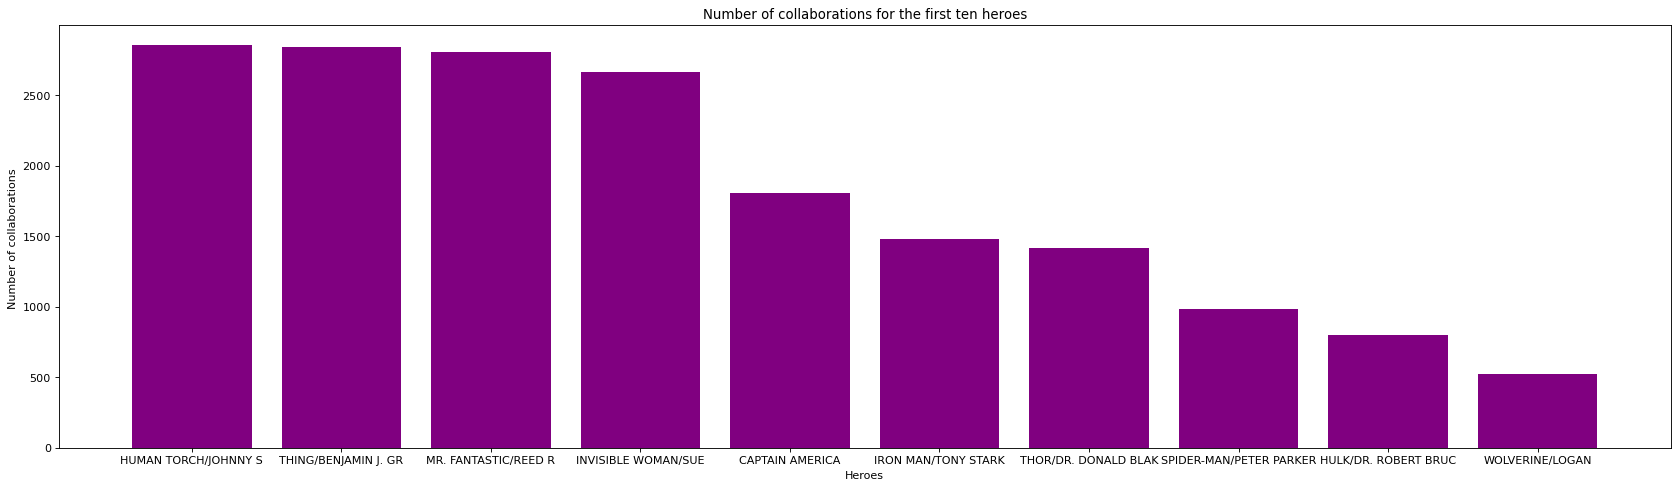

In [345]:
plt.figure(figsize=(26, 7), dpi=80)

sorted_heros = sorted(number_connections(subgraph(G1,10),1).items(), key=lambda x: x[1], reverse = True)

height = [i[1] for i in sorted_heros]
bars = [i[0] for i in sorted_heros]
x_axis = np.arange(len(bars))

plt.bar(x_axis, height, color="purple")

plt.xticks(x_axis, bars)

plt.xlabel('Heroes')
plt.ylabel('Number of collaborations ')
plt.title('Number of collaborations for the first ten heroes')

plt.show()

V4: A plot depicting the number of heroes who appeared in each comic, sorted in descending order (if the graph is type 2)

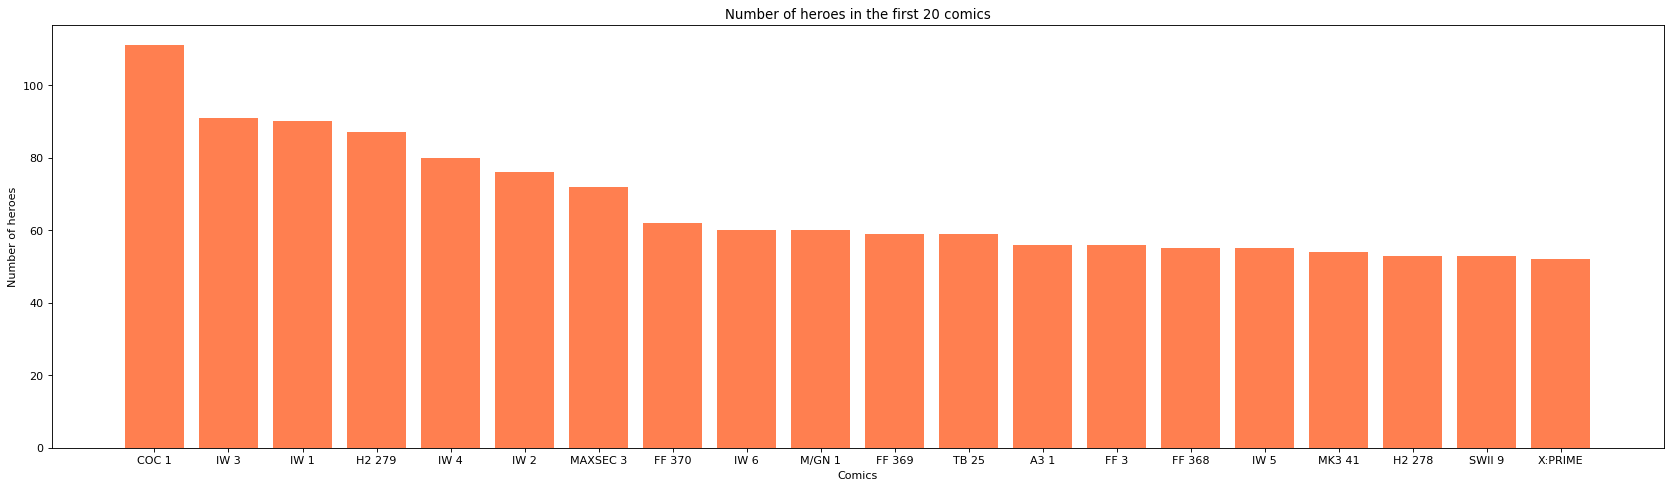

In [344]:

plt.figure(figsize=(26, 7), dpi=80)

sorted_comics = sorted(heros_per_comic(G2, 2,20).items(), key=lambda x: x[1], reverse = True)

height = [t[1] for t in sorted_comics]
bars = [t[0] for t in sorted_comics]
y_pos = np.arange(len(bars))

plt.bar(y_pos, height, color="coral")

plt.xticks(y_pos, bars)


plt.xlabel('Comics')
plt.ylabel('Number of heroes')
plt.title('Number of heroes in the first 20 comics')

plt.show()

V5: A plot depicting the degree distribution of the network

In [338]:
values = distribution_degree(G2).values()

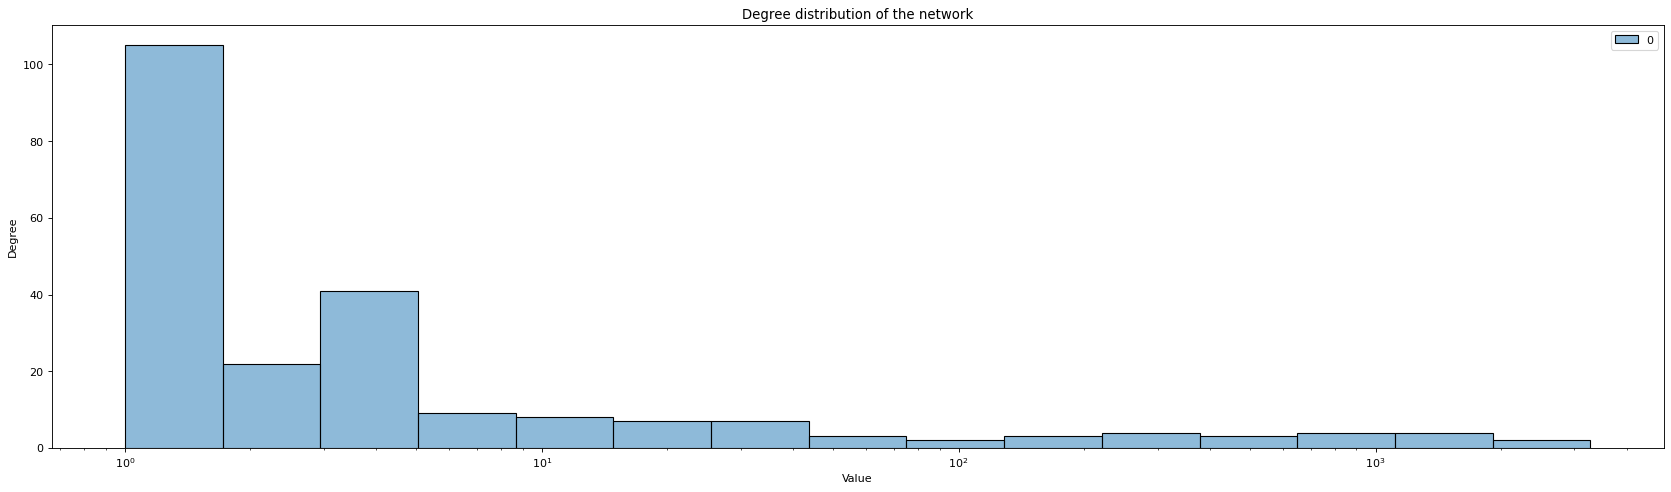

In [342]:
plt.figure(figsize=(26, 7), dpi=80)
# Plot the density graph
sns.histplot(values,log_scale=True)
plt.xlabel('Value')
plt.ylabel('Degree')
plt.title('Degree distribution of the network')
plt.show()

# Functionality 2 - Find top superheroes!

NB: I've only write the code: check if it's correct (for me it seems so) and then we have to comment it.

Input:
- The graph data
- A node (hero or comic)
- One of the given metrics : Betweeness 1, PageRank, ClosenessCentrality 3, DegreeCentrality
- N: denoting the top N heroes that their data should be considered

Output:
- The metric's value over the considered graph
- The given node's value

We start by explain the four metrics:

- Betweenness centrality: This metric measures how many times a node acts as a bridge along the shortest path between two other nodes. A node with high betweenness centrality has a large influence on the communication between other nodes in the graph. If a node has a high betweenness centrality, it means that it is likely to be a bottleneck or a gatekeeper in the communication between other nodes, as information needs to pass through it.

- PageRank: This is a measure of the importance of a node in a graph. It was developed by Google to rank web pages in their search engine. In a graph, a node with a high PageRank value is considered to be important. This can be because it has many connections to other nodes, or because it is connected to nodes that are themselves important.

- Closeness centrality: This metric measures how close a node is to all other nodes in the graph. A node with high closeness centrality has a short average distance to all other nodes. This means that it is well-connected and can reach other nodes quickly.

- Degree centrality: This measures the number of connections a node has to other nodes. A node with a high degree centrality has many connections and is well-connected in the graph.

Now, let's consider the scenario where a node has a high betweenness centrality but a low PageRank value. This could mean that the node is important in terms of acting as a bridge between other nodes, but it is not necessarily a "central" node in terms of the overall structure of the graph. On the other hand, if a node has a low betweenness centrality but a high PageRank value, it could mean that it is not a key connector between other nodes, but it is still considered an important node in the graph due to its connections to other important nodes.

In [358]:
def get_metric_value(graph, node, metric, N):

    # check if the node is in the graph 
    if node in graph.nodes():
        
        # check the N in input is valid
        if N>0: 
            
            # make the subgraph
            graph_new=subgraph(graph,N) 
            heroes=top_N_heroes(edges,N)               

            # calculate the metric's value + the respective value of the node
            if metric == "Betweeness":
                # calculate betweenness centrality
                metric_value = nx.betweenness_centrality(graph_new)
            elif metric == "PageRank":
                # calculate PageRank
                metric_value = nx.pagerank(graph_new)
            elif metric == "ClosenessCentrality":
                # calculate closeness centrality
                metric_value = nx.closeness_centrality(graph_new)
            elif metric == "DegreeCentrality":
                # calculate degree centrality
                metric_value = nx.degree_centrality(graph_new)
            else:
                raise ValueError("Invalid metric")
            
            # sort the metric values in descending order
            #sorted_metric = sorted(metric_value.items(), key=lambda x: x[1], reverse=True)

            mean_centrality = np.array(list(metric_value.values())).mean()

            if graph==G1:
                return metric_value,metric_value[node],mean_centrality
            else:
                for n in graph_new.nodes():
                    if n in heroes:
                        print(n,metric_value[n])

                return metric_value[node],mean_centrality
            
                
        else: 
            raise ValueError("N must be a positive integer")

    else: 
        raise ValueError ("The node you choose is not in the considered graph ")
    

In [ ]:
# Since this output is too long, as a matter of order we do not print it below but put the attached output as a txt file (output_funct2_G1) in the github folder.
test_one=get_metric_value(G1,'SPIDER-MAN/PETER PARKER',"DegreeCentrality",100)
test_one

In [359]:
test_two=test_two=get_metric_value(G2,'SPIDER-MAN/PETER PARKER',"ClosenessCentrality",10)
test_two

CAPTAIN AMERICA 0.3909143705233271
HULK/DR. ROBERT BRUC 0.3672628069111852
HUMAN TORCH/JOHNNY S 0.3695479777954005
INVISIBLE WOMAN/SUE 0.3640406225587405
IRON MAN/TONY STARK 0.3818468326504885
MR. FANTASTIC/REED R 0.3681108342954366
THING/BENJAMIN J. GR 0.3730525278650163
THOR/DR. DONALD BLAK 0.3727311880883529
WOLVERINE/LOGAN 0.36655170327343134
SPIDER-MAN/PETER PARKER 0.40357071480914


(0.40357071480914, 0.2856004038688739)

# Visualization 2  - Visualize centrality measure

A table containing the information related to the requested centrality measure for:

- The average of the requested centrality measure for all of the network's nodes

- The requested centrality measure's value for the given node

In [366]:
metric_value,metric_value_node,mean_centrality=get_metric_value(G1, 'SPIDER-MAN/PETER PARKER',"ClosenessCentrality",1000)

In [369]:
dataframe = pd.DataFrame([{'mean_centrality' : mean_centrality, "metric_value_node" :metric_value_node}])
dataframe.set_index(['mean_centrality', "metric_value_node"]) 

,
mean_centrality,metric_value_node
0.526327,0.772549


# Functionality 5: Extracting Communities.

Input:
- The graph data
- N: denoting the top N heroes that their data should be considered
- Hero_1: denoting the name of one of the heroes
- Hero_2: denoting the name of one of the heroes

Output:
- The minimum number of edges that should be removed to form communities
- A list of communities, each containing a list of heroes that belong to them.
- If the Hero_1 and Hero_2 belongs to the same community

Important Notes:

This functionality should only be run on the first graph.

In [35]:
'LITTLE, ABNER', 'PRINCESS ZANDA'

('LITTLE, ABNER', 'PRINCESS ZANDA')

In [37]:
from collections import defaultdict

def extract_communities(graph, N, hero_1, hero_2):
  # Create a dictionary to store the communities
  communities = defaultdict(list)

  # Keep track of the number of edges removed
  num_edges_removed = 0

  # Loop through the graph data and create the communities
  for hero, connections in graph.items():
    # If the hero is one of the top N heroes, add it to its own community
    if hero in connections[:N]:
      communities[hero].append(hero)
    else:
      # Otherwise, add the hero to the same community as one of its connections
      # that is in the top N heroes
      for connection in connections:
        if connection in connections[:N]:
          communities[connection].append(hero)
          num_edges_removed += 1
          break
  
  # Check if Hero 1 and Hero 2 belong to the same community
  same_community = False
  for community in communities.values():
    if hero_1 in community and hero_2 in community:
      same_community = True
      break
  
  return num_edges_removed, communities, same_community

In [38]:
extract_communities(G1, 10, 'LITTLE, ABNER', 'PRINCESS ZANDA')

AttributeError: 'Graph' object has no attribute 'items'